In [73]:
import torch
import numpy as np
import random

torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

if torch.cuda.is_available():
    torch.cuda.manual_seed(123)

In [74]:
# Load and preprocess data
heart_data = pd.read_csv('heart.csv')
node_features = torch.tensor(heart_data.drop('target', axis=1).values, dtype=torch.float)
node_labels = torch.tensor(heart_data['target'].values, dtype=torch.long)
num_nodes = heart_data.shape[0]

In [75]:
# Create edges for a fully connected graph
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)


In [76]:
# Set up the Data object and transform features
data = Data(x=node_features, edge_index=edge_index, y=node_labels)
transform = NormalizeFeatures()
data = transform(data)


In [77]:
# Split data into train, validation, and test sets
train_idx, test_idx = train_test_split(torch.arange(num_nodes), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)


In [78]:
# Set up data loaders for neighbor sampling
train_loader = NeighborLoader(data, input_nodes=train_idx, batch_size=32, num_neighbors=[10, 10], shuffle=True)
val_loader = NeighborLoader(data, input_nodes=val_idx, batch_size=64, num_neighbors=[10, 10], shuffle=False)
test_loader = NeighborLoader(data, input_nodes=test_idx, batch_size=64, num_neighbors=[10, 10], shuffle=False)


In [79]:
# Define the GNN Model with Two SAGEConv Layers
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


In [80]:
# Set up model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(input_dim=data.num_node_features, hidden_dim=64, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


In [81]:
# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        
        valid_indices = batch.input_id < batch.x.size(0)
        input_id = batch.input_id[valid_indices]
        
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out[input_id], batch.y[input_id])
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            correct += pred.eq(batch.y[batch.input_id]).sum().item()
            total += batch.input_id.size(0)
    return correct / total


In [82]:
# Training loop with loss and accuracy tracking
train_losses = []
val_accuracies = []
num_epochs = 1000
for epoch in range(1, num_epochs + 1):
    loss = train()
    val_acc = evaluate(val_loader)
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}')


Epoch 1, Loss: 0.6941, Validation Accuracy: 0.4706
Epoch 2, Loss: 0.6888, Validation Accuracy: 0.6275
Epoch 3, Loss: 0.6924, Validation Accuracy: 0.5000
Epoch 4, Loss: 0.6838, Validation Accuracy: 0.4510
Epoch 5, Loss: 0.6724, Validation Accuracy: 0.5588
Epoch 6, Loss: 0.6705, Validation Accuracy: 0.6471
Epoch 7, Loss: 0.6549, Validation Accuracy: 0.6275
Epoch 8, Loss: 0.6427, Validation Accuracy: 0.5980
Epoch 9, Loss: 0.6255, Validation Accuracy: 0.7157
Epoch 10, Loss: 0.6186, Validation Accuracy: 0.6961
Epoch 11, Loss: 0.6262, Validation Accuracy: 0.5882
Epoch 12, Loss: 0.5901, Validation Accuracy: 0.6961
Epoch 13, Loss: 0.5640, Validation Accuracy: 0.6471
Epoch 14, Loss: 0.5570, Validation Accuracy: 0.6667
Epoch 15, Loss: 0.5512, Validation Accuracy: 0.6275
Epoch 16, Loss: 0.5688, Validation Accuracy: 0.6961
Epoch 17, Loss: 0.5521, Validation Accuracy: 0.6961
Epoch 18, Loss: 0.5301, Validation Accuracy: 0.7255
Epoch 19, Loss: 0.5764, Validation Accuracy: 0.7255
Epoch 20, Loss: 0.526

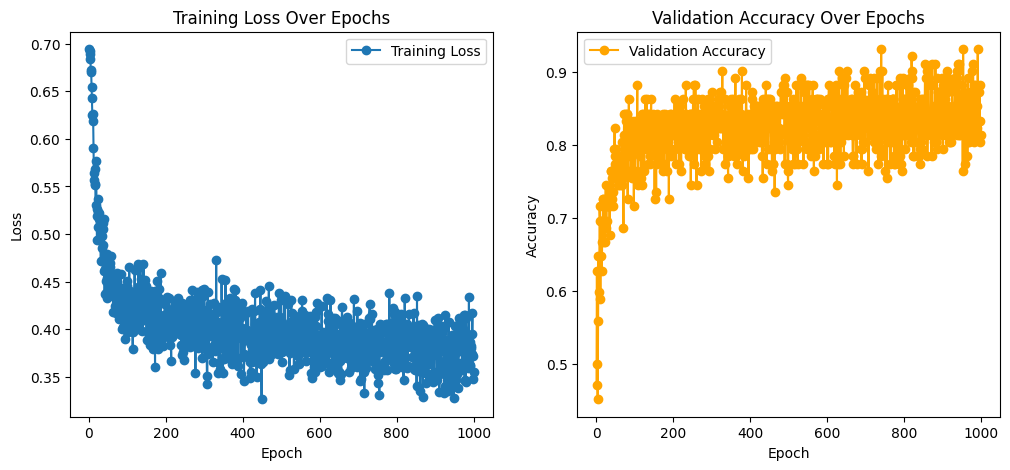

In [83]:
# Plot the loss and accuracy line graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.show()


In [84]:
# Test accuracy
test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8447


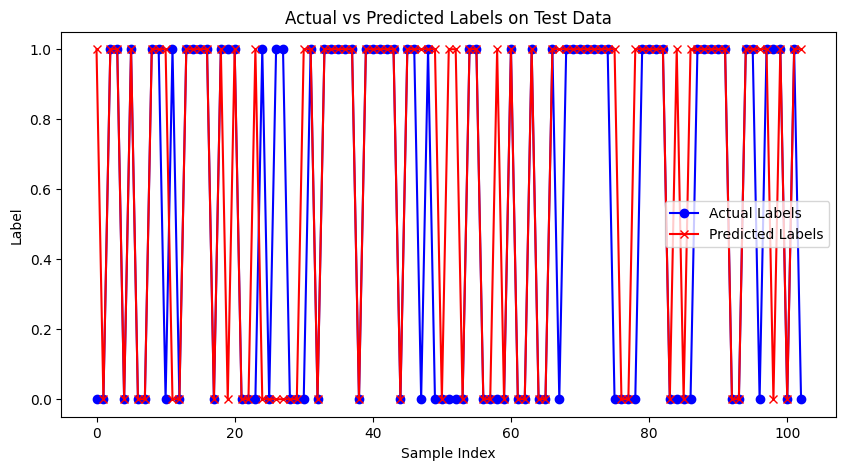

In [85]:
# Generate and plot actual vs. predicted labels as a line graph
def plot_test_predictions_vs_actual_line(loader):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            true_labels.append(batch.y[batch.input_id].cpu())
            pred_labels.append(pred.cpu())
    
    true_labels = torch.cat(true_labels).numpy()
    pred_labels = torch.cat(pred_labels).numpy()
    
    # Plot actual vs predicted labels as a line graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(true_labels)), true_labels, label="Actual Labels", marker='o', color="blue")
    plt.plot(range(len(pred_labels)), pred_labels, label="Predicted Labels", marker='x', color="red")
    plt.xlabel("Sample Index")
    plt.ylabel("Label")
    plt.title("Actual vs Predicted Labels on Test Data")
    plt.legend()
    plt.show()

# Plot actual vs predicted comparison
plot_test_predictions_vs_actual_line(test_loader)


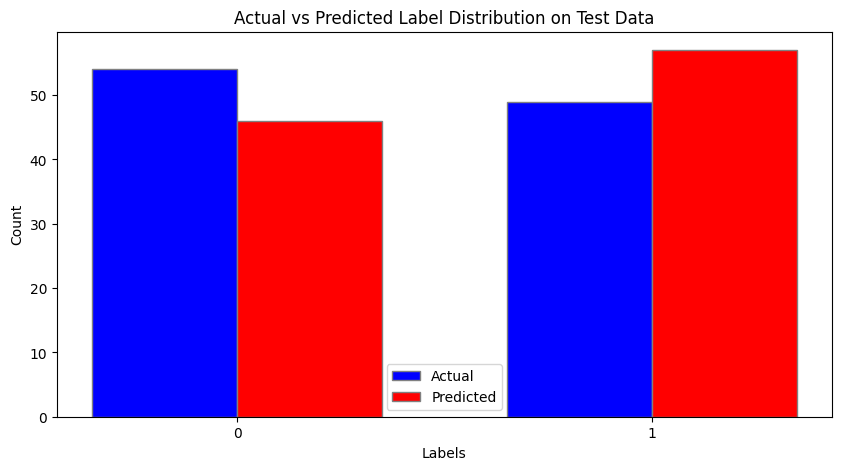

In [86]:
# Generate and plot actual vs. predicted labels as a bar chart
def plot_test_predictions_vs_actual(loader):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            true_labels.append(batch.y[batch.input_id].cpu())
            pred_labels.append(pred.cpu())
    
    true_labels = torch.cat(true_labels).numpy()
    pred_labels = torch.cat(pred_labels).numpy()
    
    # Plot actual vs predicted labels as a bar chart
    plt.figure(figsize=(10, 5))
    labels, counts = np.unique(true_labels, return_counts=True)
    pred_labels_counts = [np.sum(pred_labels == label) for label in labels]
    
    bar_width = 0.35
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    
    plt.bar(r1, counts, color='blue', width=bar_width, edgecolor='grey', label='Actual')
    plt.bar(r2, pred_labels_counts, color='red', width=bar_width, edgecolor='grey', label='Predicted')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title("Actual vs Predicted Label Distribution on Test Data")
    plt.xticks([r + bar_width / 2 for r in range(len(labels))], labels)
    plt.legend()
    plt.show()

# Plot actual vs predicted comparison
plot_test_predictions_vs_actual(test_loader)

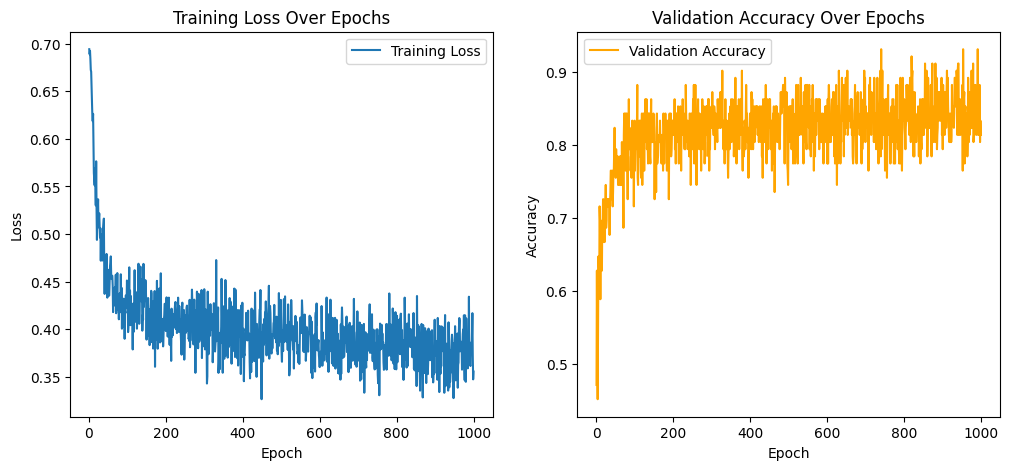

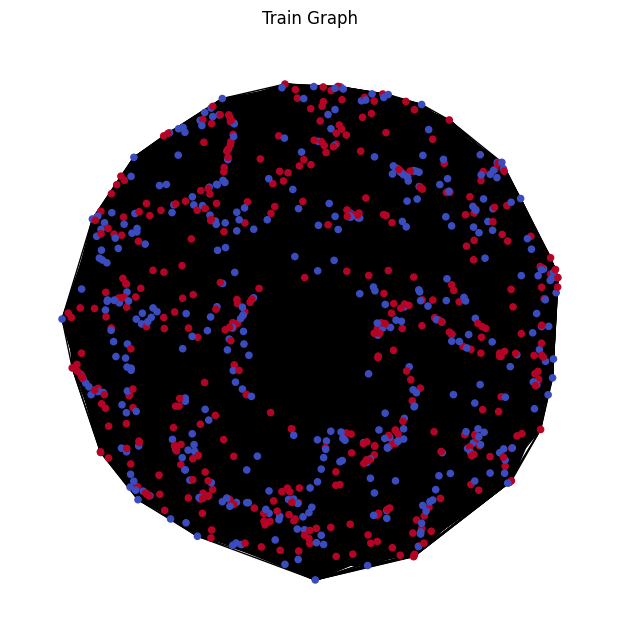

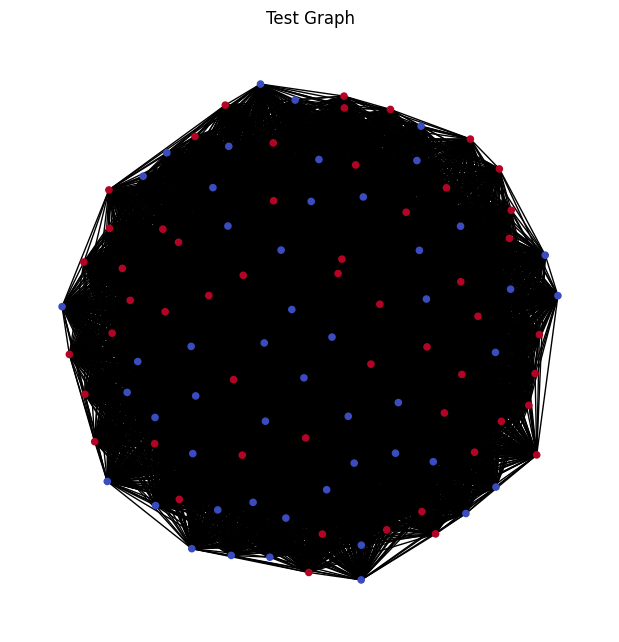

Test Accuracy: 0.8155


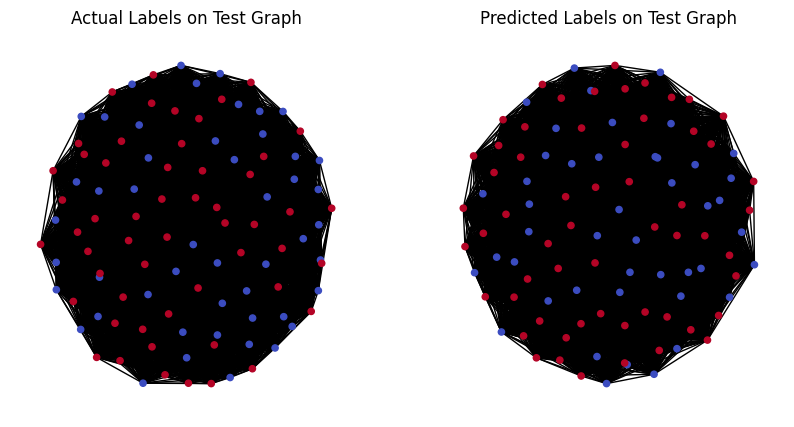

In [87]:
import torch
import numpy as np
import random
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import networkx as nx

# Visualization functions
def plot_split_graphs(train_idx, val_idx, test_idx, data):
    split_indices = {'Train': train_idx, 'Test': test_idx}
    for split_name, indices in split_indices.items():
        G = nx.Graph()
        
        # Filter edges for the specific split
        mask_src = torch.isin(data.edge_index[0], indices)
        mask_dst = torch.isin(data.edge_index[1], indices)
        edge_mask = mask_src & mask_dst

        edge_subset = data.edge_index[:, edge_mask]
        G.add_edges_from(edge_subset.t().tolist())
        
        plt.figure(figsize=(6, 6))
        nx.draw(G, with_labels=False, node_size=20, node_color=data.y[indices].numpy(), cmap="coolwarm")
        plt.title(f"{split_name} Graph")
        plt.show()

def plot_test_predictions_vs_actual(loader):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            true_labels.append(batch.y[batch.input_id].cpu())
            pred_labels.append(pred.cpu())
    
    true_labels = torch.cat(true_labels)
    pred_labels = torch.cat(pred_labels)
    
    G = nx.Graph()
    test_edge_subset = data.edge_index[:, 
                       (torch.isin(data.edge_index[0], test_idx) & torch.isin(data.edge_index[1], test_idx))]

    G.add_edges_from(test_edge_subset.t().tolist())
    
    # Plot actual labels
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    nx.draw(G, with_labels=False, node_size=20, node_color=true_labels.numpy(), cmap="coolwarm")
    plt.title("Actual Labels on Test Graph")
    
    # Plot predicted labels
    plt.subplot(1, 2, 2)
    nx.draw(G, with_labels=False, node_size=20, node_color=pred_labels.numpy(), cmap="coolwarm")
    plt.title("Predicted Labels on Test Graph")
    plt.show()


# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.show()

# Plot train and test data graphs
plot_split_graphs(train_idx, val_idx, test_idx, data)

# Final test accuracy
test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot actual vs. predicted labels on test graph
plot_test_predictions_vs_actual(test_loader)

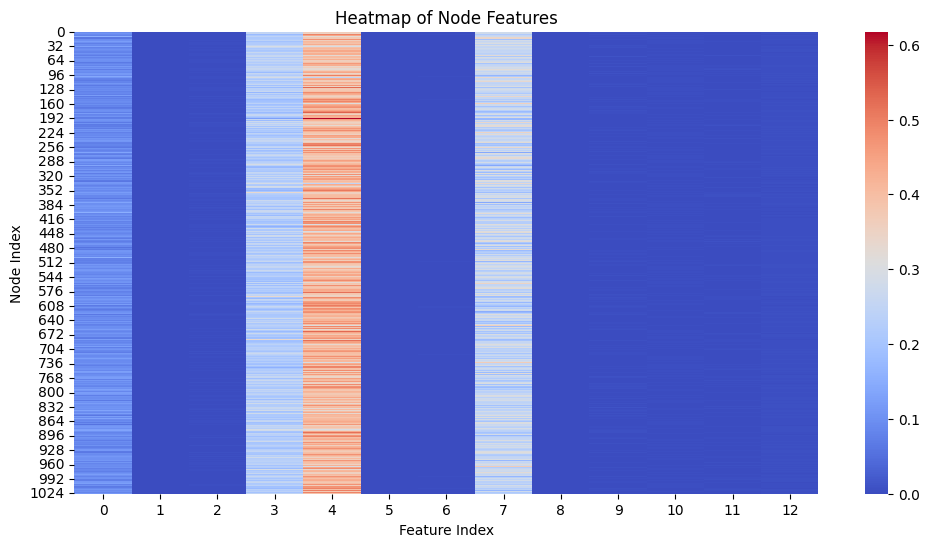

In [88]:
import seaborn as sns

# Create a heatmap for node features
def plot_node_features_heatmap(data):
    feature_data = data.x.cpu().numpy()
    plt.figure(figsize=(12, 6))
    sns.heatmap(feature_data, cmap="coolwarm", cbar=True)
    plt.title("Heatmap of Node Features")
    plt.xlabel("Feature Index")
    plt.ylabel("Node Index")
    plt.show()

# Call the function to plot the heatmap
plot_node_features_heatmap(data)


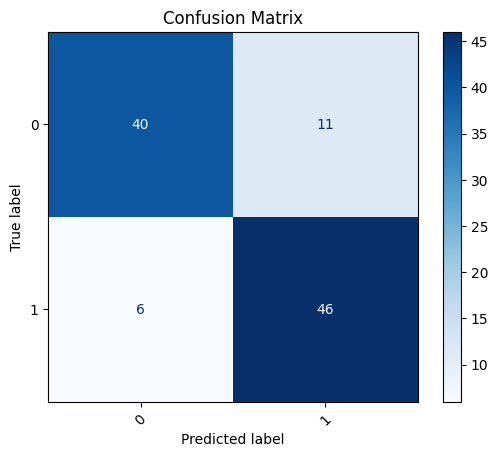

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
def plot_confusion_matrix(loader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            true_labels.append(batch.y[batch.input_id].cpu())
            pred_labels.append(pred.cpu())

    true_labels = torch.cat(true_labels).numpy()
    pred_labels = torch.cat(pred_labels).numpy()

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Call the function for test data
plot_confusion_matrix(test_loader)


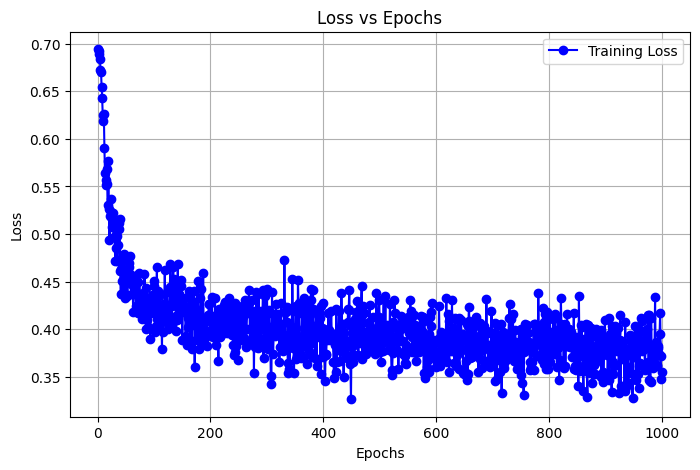

In [90]:
# Plot loss vs. epochs graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
from sklearn.metrics import classification_report

# Generate performance metrics
def calculate_performance_metrics(loader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            pred = out[batch.input_id].argmax(dim=1)
            true_labels.append(batch.y[batch.input_id].cpu())
            pred_labels.append(pred.cpu())

    true_labels = torch.cat(true_labels).numpy()
    pred_labels = torch.cat(pred_labels).numpy()

    report = classification_report(true_labels, pred_labels, target_names=["Class 0", "Class 1"])
    print("Classification Report:\n")
    print(report)

# Call the function for test data
calculate_performance_metrics(test_loader)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.82      0.74      0.78        42
     Class 1       0.83      0.89      0.86        61

    accuracy                           0.83       103
   macro avg       0.82      0.81      0.82       103
weighted avg       0.82      0.83      0.82       103

